# Load pretrained model from keras. applications

In [29]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import cv2
import os


In [74]:
# prediction index and probability value
def get_preds_index_value(x):
    preds = model. predict(x)
    preds_index = np.argmax(preds)
    preds_proba = preds[0][preds_index]
    return preds_index,preds_proba

#de-proprocess the modified image: inversed process of caffe
def de_preprocess_input(img):
    
    mean = [103.939, 116.779, 123.68]
    img[...,0] +=mean[0]
    img[...,1] +=mean[1]
    img[...,2] +=mean[2]
    img = img[...,::-1] #bgr -> rgb
    img = img/255
    img =img.reshape(224,224,3)
    img =np.clip(img,0.0,1.0)
    return img

#FGSM algorithm
def fgsm(x,epsilon):
    
    y_index, y_true = get_preds_index_value(x)
    loss = - K.log(model.output[0][y_index]) # define the loss function

    gradients = K.gradients(loss, model.input) 
    
    sess = K.get_session()
    gradient_x = sess.run(gradients[0], feed_dict={model.input: x})
    
    y_sign = np.sign(gradient_x)
    x_adv = x + epsilon * y_sign
    return x_adv

#clip function for BIM
def clip(x,x_source_image,epsilon):
    return np.clip(x,x_source_image - epsilon,x_source_image + epsilon )

#Basic Iterative Method: https://arxiv.org/pdf/1607.02533.pdf
def bim(x,epsilon):
    iterations = min(epsilon, 1.25* epsilon)
    y_index, y_true = get_preds_index_value(x)
    alpha = 1 
    x_sourse_image = x
    for i in range(iterations):
        loss = - K.log(model.output[0][y_index]) # define the loss function
        gradients = K.gradients(loss, model.input) 
        sess = K.get_session()
        gradient_x = sess.run(gradients[0], feed_dict={model.input: x})
        y_sign = np.sign(gradient_x)        
        x = x + alpha * y_sign
        x = clip(x,x_sourse_image,epsilon)
    return x
        

#Attack action
def attack(filename,epsilon,method,blur):
    img = image.load_img(input_path+filename, target_size=(224, 224))
    x = image.img_to_array(img)

       
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) #image preprocess before sending into ResNet50. the algorithm is caffe
    
    if method== 'FGSM':
        x_adv = fgsm(x,epsilon) # get modified images by FGSM
    elif method == 'BIM':
        x_adv = bim(x,epsilon) # get modified images by BIM
        
    
    
    
    if blur == 1: #make the adversrial image blur
        x_adv = x_adv.reshape(224,224,3)
        x_adv = cv2.blur(x_adv,(5,5))
        x_adv = x_adv.reshape(1,224,224,3)
    
    
    preds = model.predict(x)
    print(f'{filename} Predicted_x:', decode_predictions(preds, top=3)[0])
    preds_adv = model.predict(x_adv)
    print(f'{filename} Predicted_x_adv:',decode_predictions(preds_adv, top=3)[0])
    
    if decode_predictions(preds, top=3)[0][0][0] !=decode_predictions(preds_adv, top=3)[0][0][0]: # the tag of the category
        is_success = 1
        print("attack successful")
    else:
        is_success = 0
        print("attack failed")
    
    # calculate L-infinity
    l_inf = np.max(np.absolute(x_adv-x))
    l_inf = round(l_inf,2)
    print(f"l-infinity: {l_inf}")
    img_x = de_preprocess_input(x_adv) # inversed process of preprocess to get the correct image
    
    plt.imsave(output_path + filename,img_x) # save the image
    plt.close()
    
    
    return is_success,l_inf #return the success status and l_inf

In [75]:
DIR_MAC= '/Users/haipengwu/Codings/Machine Learning/HW5/images/'
DIR_1080="C:\\Users\\WIN10\\Codings\\Machine Learning\\HW5\\images\\"

input_path = DIR_1080 + 'inputs/' #set input path of original images
output_path = DIR_1080 + 'outputs/' #set output path of modified images
filenames = os.listdir(input_path) #get all of the images names
EPSILON = 4 # set the epsilon value for the FGSM algorithm
BLUR = 1 # filtering to smooth the picture for passive defense ,set 1 if blurring method is applied 
total_success = 0 # for calculating success rate
total_l_inf = 0
METHOD = 'FGSM' # BIM or FGSM
print("START......\n")
if BLUR ==1:
     print("Median_Filtering is applied...")


for filename in filenames:
    
    # for each loop, LOAD the model and CLEAR the session in the end in order to avoid the MEMORY INCREASE!!!
    model = ResNet50(weights='imagenet')
    is_success,l_inf = attack(filename, epsilon=EPSILON,method = METHOD,blur = BLUR)
    total_success+=is_success
    total_l_inf +=l_inf
    K.clear_session()
    
success_rate  = round(total_success/ len(filenames),4)
avg_l_inf = round(total_l_inf/ len(filenames),2)
print(f"success_rate: {success_rate *100}%")
print(f"average_l-infinity: {avg_l_inf}")
print("......FINISHED")

START......

Median_Filtering is applied...
000.png Predicted_x: [('n02172182', 'dung_beetle', 0.9673014), ('n02167151', 'ground_beetle', 0.02390268), ('n02174001', 'rhinoceros_beetle', 0.0052274386)]
000.png Predicted_x_adv: [('n02167151', 'ground_beetle', 0.34003618), ('n02219486', 'ant', 0.14069459), ('n02169497', 'leaf_beetle', 0.13048209)]
attack successful
l-infinity: 115.4800033569336
001.png Predicted_x: [('n04522168', 'vase', 0.8794097), ('n03991062', 'pot', 0.06169799), ('n01833805', 'hummingbird', 0.022370284)]
001.png Predicted_x_adv: [('n03991062', 'pot', 0.22602479), ('n04522168', 'vase', 0.12814485), ('n01531178', 'goldfinch', 0.07146412)]
attack successful
l-infinity: 192.8000030517578
002.png Predicted_x: [('n02108422', 'bull_mastiff', 0.7852003), ('n02108089', 'boxer', 0.20606609), ('n02093428', 'American_Staffordshire_terrier', 0.0034690732)]
002.png Predicted_x_adv: [('n02108089', 'boxer', 0.9629968), ('n02108422', 'bull_mastiff', 0.03319259), ('n02111129', 'Leonber

025.png Predicted_x: [('n01855672', 'goose', 0.99139845), ('n01860187', 'black_swan', 0.005727867), ('n01806143', 'peacock', 0.0011128265)]
025.png Predicted_x_adv: [('n01855672', 'goose', 0.65846705), ('n01855032', 'red-breasted_merganser', 0.090237476), ('n01798484', 'prairie_chicken', 0.03765879)]
attack failed
l-infinity: 125.08000183105469
026.png Predicted_x: [('n02966193', 'carousel', 0.85430926), ('n04346328', 'stupa', 0.045785192), ('n04296562', 'stage', 0.01234326)]
026.png Predicted_x_adv: [('n01740131', 'night_snake', 0.10485354), ('n01930112', 'nematode', 0.09469996), ('n01784675', 'centipede', 0.07411672)]
attack successful
l-infinity: 212.72000122070312
027.png Predicted_x: [('n02110341', 'dalmatian', 0.9772799), ('n02128925', 'jaguar', 0.013921415), ('n02128385', 'leopard', 0.0046456503)]
027.png Predicted_x_adv: [('n02128925', 'jaguar', 0.51276445), ('n02128385', 'leopard', 0.37425458), ('n02130308', 'cheetah', 0.047982674)]
attack successful
l-infinity: 123.8799972534

050.png Predicted_x: [('n04019541', 'puck', 0.99999106), ('n04228054', 'ski', 6.99887e-06), ('n03623198', 'knee_pad', 1.074728e-06)]
050.png Predicted_x_adv: [('n04019541', 'puck', 0.9968244), ('n04228054', 'ski', 0.0025335196), ('n02835271', 'bicycle-built-for-two', 0.00024291387)]
attack failed
l-infinity: 164.72000122070312
051.png Predicted_x: [('n04090263', 'rifle', 0.3291778), ('n02749479', 'assault_rifle', 0.18271321), ('n03759954', 'microphone', 0.041426588)]
051.png Predicted_x_adv: [('n01558993', 'robin', 0.10493486), ('n01530575', 'brambling', 0.08700699), ('n01532829', 'house_finch', 0.06903158)]
attack successful
l-infinity: 120.68000030517578
052.png Predicted_x: [('n07745940', 'strawberry', 0.66560835), ('n07930864', 'cup', 0.15017198), ('n07836838', 'chocolate_sauce', 0.016090818)]
052.png Predicted_x_adv: [('n07745940', 'strawberry', 0.14369786), ('n07930864', 'cup', 0.06888613), ('n03729826', 'matchstick', 0.053130016)]
attack failed
l-infinity: 143.8800048828125
053.

075.png Predicted_x: [('n03775546', 'mixing_bowl', 0.7869556), ('n04332243', 'strainer', 0.0361237), ('n03633091', 'ladle', 0.024712982)]
075.png Predicted_x_adv: [('n02823750', 'beer_glass', 0.1747288), ('n02815834', 'beaker', 0.11820977), ('n04560804', 'water_jug', 0.080832854)]
attack successful
l-infinity: 162.52000427246094
076.png Predicted_x: [('n03717622', 'manhole_cover', 0.85981053), ('n02910353', 'buckle', 0.03947275), ('n03920288', 'Petri_dish', 0.0150524415)]
076.png Predicted_x_adv: [('n02978881', 'cassette', 0.6457539), ('n03920288', 'Petri_dish', 0.027116561), ('n04589890', 'window_screen', 0.024104862)]
attack successful
l-infinity: 157.8000030517578
077.png Predicted_x: [('n07920052', 'espresso', 0.9938148), ('n07932039', 'eggnog', 0.0025348207), ('n03063599', 'coffee_mug', 0.0019692993)]
077.png Predicted_x_adv: [('n07920052', 'espresso', 0.31295294), ('n03063599', 'coffee_mug', 0.1528847), ('n07930864', 'cup', 0.149217)]
attack failed
l-infinity: 106.87999725341797


100.png Predicted_x: [('n02966193', 'carousel', 0.98774), ('n04081281', 'restaurant', 0.005279448), ('n03899768', 'patio', 0.00049429684)]
100.png Predicted_x_adv: [('n02966193', 'carousel', 0.93957484), ('n03661043', 'library', 0.008271358), ('n01704323', 'triceratops', 0.0074937623)]
attack failed
l-infinity: 202.9600067138672
101.png Predicted_x: [('n02769748', 'backpack', 0.2899687), ('n03459775', 'grille', 0.078270234), ('n03976467', 'Polaroid_camera', 0.044063825)]
101.png Predicted_x_adv: [('n03868863', 'oxygen_mask', 0.114664435), ('n03584829', 'iron', 0.10115844), ('n03271574', 'electric_fan', 0.07307373)]
attack successful
l-infinity: 159.55999755859375
102.png Predicted_x: [('n03538406', 'horse_cart', 0.98817945), ('n04428191', 'thresher', 0.0034665805), ('n03868242', 'oxcart', 0.0020523225)]
102.png Predicted_x_adv: [('n03538406', 'horse_cart', 0.4867903), ('n03868242', 'oxcart', 0.11022827), ('n04428191', 'thresher', 0.10302112)]
attack failed
l-infinity: 177.8399963378906

125.png Predicted_x: [('n03733281', 'maze', 0.99432856), ('n07714571', 'head_cabbage', 0.00230701), ('n04326547', 'stone_wall', 0.0009729029)]
125.png Predicted_x_adv: [('n03733281', 'maze', 0.72121894), ('n04326547', 'stone_wall', 0.022015251), ('n03445777', 'golf_ball', 0.01057881)]
attack failed
l-infinity: 156.39999389648438
126.png Predicted_x: [('n03259280', 'Dutch_oven', 0.2917887), ('n03400231', 'frying_pan', 0.2390195), ('n07614500', 'ice_cream', 0.08136712)]
126.png Predicted_x_adv: [('n07717410', 'acorn_squash', 0.10304244), ('n01981276', 'king_crab', 0.09913133), ('n01978287', 'Dungeness_crab', 0.086218506)]
attack successful
l-infinity: 125.04000091552734
127.png Predicted_x: [('n02939185', 'caldron', 0.91110474), ('n03259280', 'Dutch_oven', 0.03735283), ('n03633091', 'ladle', 0.032503743)]
127.png Predicted_x_adv: [('n02939185', 'caldron', 0.72322625), ('n03633091', 'ladle', 0.086060494), ('n03259280', 'Dutch_oven', 0.037268937)]
attack failed
l-infinity: 113.599998474121

150.png Predicted_x: [('n02536864', 'coho', 0.7096693), ('n01484850', 'great_white_shark', 0.12205988), ('n02641379', 'gar', 0.07873987)]
150.png Predicted_x_adv: [('n02066245', 'grey_whale', 0.25242653), ('n01484850', 'great_white_shark', 0.15094092), ('n02071294', 'killer_whale', 0.114788316)]
attack successful
l-infinity: 179.27999877929688
151.png Predicted_x: [('n02497673', 'Madagascar_cat', 0.9231555), ('n02500267', 'indri', 0.06712523), ('n02484975', 'guenon', 0.0021696223)]
151.png Predicted_x_adv: [('n02500267', 'indri', 0.5109872), ('n02497673', 'Madagascar_cat', 0.17257507), ('n02494079', 'squirrel_monkey', 0.09676098)]
attack successful
l-infinity: 140.32000732421875
152.png Predicted_x: [('n02782093', 'balloon', 0.22492649), ('n03888257', 'parachute', 0.18202998), ('n02814860', 'beacon', 0.13421075)]
152.png Predicted_x_adv: [('n09428293', 'seashore', 0.10470118), ('n09421951', 'sandbar', 0.053619243), ('n02814860', 'beacon', 0.04146677)]
attack successful
l-infinity: 148.

175.png Predicted_x: [('n03133878', 'Crock_Pot', 0.9829714), ('n07565083', 'menu', 0.007955381), ('n03871628', 'packet', 0.0018799254)]
175.png Predicted_x_adv: [('n03133878', 'Crock_Pot', 0.6326568), ('n04525305', 'vending_machine', 0.11162893), ('n03761084', 'microwave', 0.054066107)]
attack failed
l-infinity: 165.0800018310547
176.png Predicted_x: [('n03717622', 'manhole_cover', 0.9991067), ('n04355338', 'sundial', 0.00058852555), ('n04542943', 'waffle_iron', 0.00013856016)]
176.png Predicted_x_adv: [('n04542943', 'waffle_iron', 0.89488393), ('n04355338', 'sundial', 0.053318445), ('n03717622', 'manhole_cover', 0.026508313)]
attack successful
l-infinity: 166.83999633789062
177.png Predicted_x: [('n03781244', 'monastery', 0.9631441), ('n03028079', 'church', 0.034874767), ('n02825657', 'bell_cote', 0.0006844871)]
177.png Predicted_x_adv: [('n03781244', 'monastery', 0.98115176), ('n03028079', 'church', 0.014708576), ('n02825657', 'bell_cote', 0.0009190747)]
attack failed
l-infinity: 152

199.png Predicted_x: [('n04037443', 'racer', 0.7332748), ('n04285008', 'sports_car', 0.23982045), ('n02974003', 'car_wheel', 0.022632465)]
199.png Predicted_x_adv: [('n04285008', 'sports_car', 0.72221214), ('n04037443', 'racer', 0.2531381), ('n02974003', 'car_wheel', 0.0123394765)]
attack successful
l-infinity: 157.67999267578125
success_rate: 60.0%
average_l-infinity: 147.41
......FINISHED


# With smoothing method, the FGSM attack success rate drops from 93% to 60%. The change is significant, meaning that the smoothing way of passive defense works.

# Draw the picture

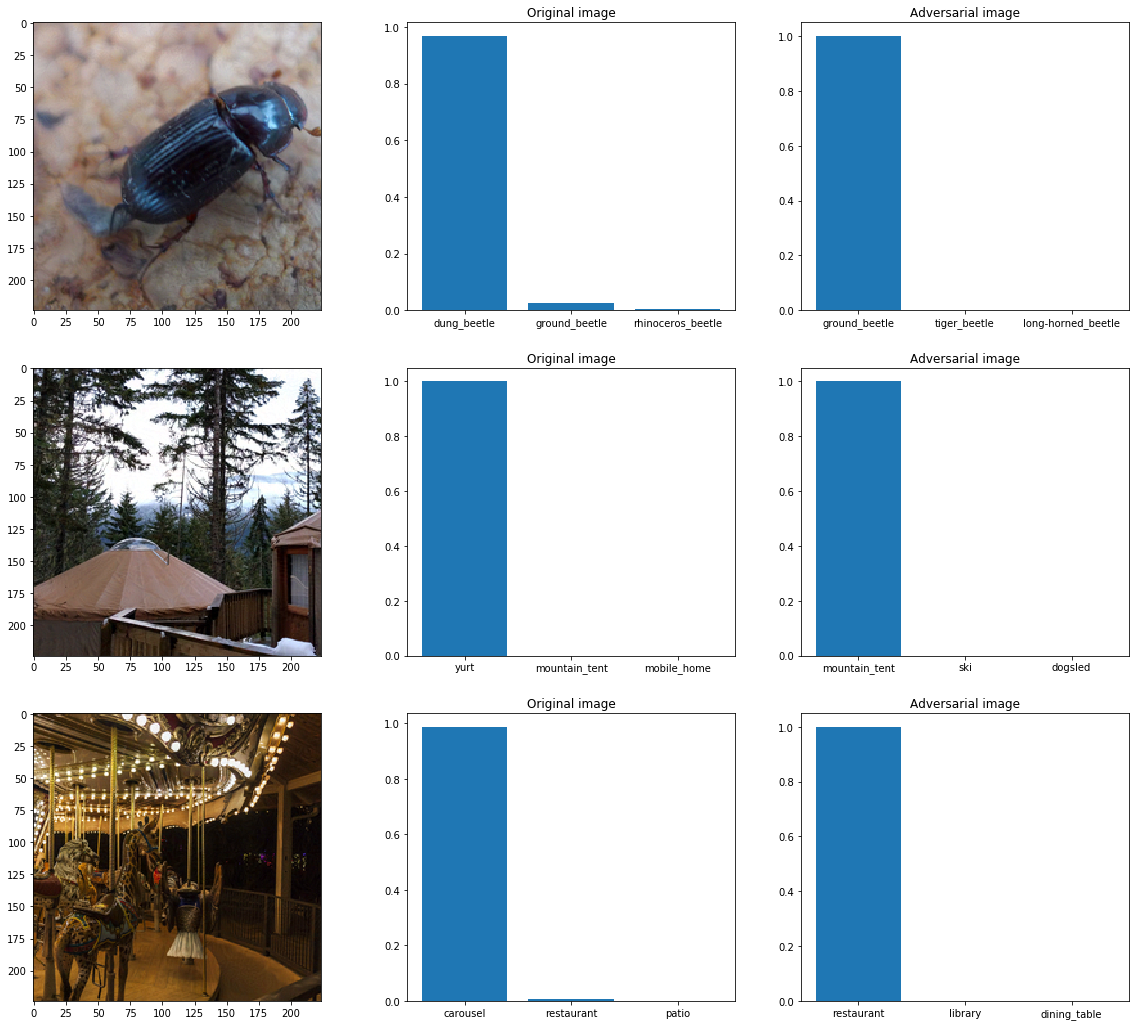

In [26]:
DIR_MAC= '/Users/haipengwu/Codings/Machine Learning/HW5/images/'
DIR_1080="C:\\Users\\WIN10\\Codings\\Machine Learning\\HW5\\images\\"

input_path = DIR_1080 + 'inputs/' #set input path of original images
output_path = DIR_1080 + 'outputs/' #set output path of modified images
filenames = os.listdir(input_path) #get all of the images names
EPSILON = 4 # set the epsilon value for the FGSM algorithm
model = ResNet50(weights='imagenet')

FILENAMES = ['000.png','010.png','100.png']

def draw_picture(filenames):
    
    
    fig, ax = plt.subplots(len(filenames), 3, figsize = (20, len(filenames)*6))

    for i,filename in enumerate(filenames):


        img = image.load_img(input_path+filename, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x) #image preprocess before sending into ResNet50. the algorithm is caffe
        x_adv = bim(x,epsilon=EPSILON) # get modified images by BIM

        preds = model.predict(x)
        preds_adv = model.predict(x_adv)



        before_preds = decode_predictions(preds, top=3)[0]
        after_preds = decode_predictions(preds_adv, top=3)[0]

        before_preds_names = [before_preds[i][1] for i in range(3)] # get the names information of the top 3 predictions 
        before_preds_proba = [before_preds[i][2] for i in range(3)] # get the prob information of the top 3 predictions 

        after_preds_names = [after_preds[i][1] for i in range(3)]
        after_preds_proba = [after_preds[i][2] for i in range(3)]


        img_x = de_preprocess_input(x_adv)




        ax[i,0].imshow(img_x)

        ax[i,1].bar(before_preds_names,before_preds_proba)
        ax[i,1].set_title('Original image')

        ax[i,2].bar(after_preds_names,after_preds_proba)
        ax[i,2].set_title('Adversarial image')

    plt.show()
    plt.close()
    K.clear_session()

draw_picture(FILENAMES)
